# Pymatching vs Pfaffian Decoder Comparison

Compares logical error rates on the same sampled noise for `L = 3, 5, 7, 9` using: 
- `pymatching` (batch decode) 
- `decoders.pfaffian_decoder.decode` (shot-by-shot) 
 
This uses the X-check matrix `Hx` to decode Z errors and a Z logical observable.

In [21]:
%%time
from pathlib import Path
import sys
from time import perf_counter

import numpy as np
import matplotlib.pyplot as plt
from pymatching import Matching

# Ensure project root is importable when running from repo root or sim/ 
cwd = Path.cwd().resolve() 
candidate_roots = [cwd, *cwd.parents] 
project_root = next((p for p in candidate_roots if (p / 'parity_checks.py').exists()), cwd) 
if str(project_root) not in sys.path: 
    sys.path.insert(0, str(project_root)) 
 
from parity_checks import create_H 
from logicals import create_logical 
from decoders.pfaffian_decoder import decode as pfaffian_decode 

CPU times: user 490 μs, sys: 756 μs, total: 1.25 ms
Wall time: 873 μs


In [22]:
def _logical_row_dense(logicals):  
    if hasattr(logicals, 'toarray'):  
        arr = np.asarray(logicals.toarray(), dtype=np.uint8)  
    else:  
        arr = np.asarray(logicals, dtype=np.uint8)  
    if arr.ndim == 1:  
        return arr.reshape(1, -1)  
    return arr  
  
  
def compare_decoders_shared_noise(Hx, logicals, p, num_shots, rng):  
    """  
    Returns metrics for Pymatching vs Pfaffian on the same sampled noise.  
    """  
    logicals_dense = _logical_row_dense(logicals)  
    num_qubits = Hx.shape[1]  
  
    matching = Matching.from_check_matrix(  
        Hx,  
        weights=np.log((1 - p) / p),  
        faults_matrix=logicals,  
    )  
  
    noise = (rng.random((num_shots, num_qubits)) < p).astype(np.uint8)  
    syndromes = (noise @ Hx.T) % 2  
    actual_obs = (noise @ logicals_dense.T) % 2  
  
    t0 = perf_counter()  
    pm_pred_obs = matching.decode_batch(syndromes)  
    t_pm = perf_counter() - t0  
    pm_fail = int(np.sum(np.any(pm_pred_obs != actual_obs, axis=1)))  
  
    pf_pred_obs = np.zeros_like(actual_obs, dtype=np.uint8)  
    t1 = perf_counter()  
    for i in range(num_shots):  
        corr = pfaffian_decode(Hx, logicals, syndromes[i], p)  
        pf_pred_obs[i] = (corr @ logicals_dense.T) % 2  
    t_pf = perf_counter() - t1  
    pf_fail = int(np.sum(np.any(pf_pred_obs != actual_obs, axis=1)))  
  
    agreement = float(np.mean(np.all(pm_pred_obs == pf_pred_obs, axis=1)))  
  
    return {  
        'pm_fail': pm_fail,  
        'pf_fail': pf_fail,  
        'pm_rate': pm_fail / num_shots,  
        'pf_rate': pf_fail / num_shots,  
        'agreement': agreement,  
        't_pm_s': t_pm,  
        't_pf_s': t_pf,  
    }  

In [23]:
%%time  
# --- Simulation settings ---  
num_shots = 1000  # increase later (Pfaffian decoder is much slower than Pymatching)  
Ls = [9]  
ps = np.linspace(0.01, 0.5, 20) 
seed = 12345  
  
rng = np.random.default_rng(seed)  
results = {}  
timings_by_L = []  
  
print(f'Comparing decoders on shared noise | shots={num_shots} | ps={ps.tolist()}')  
  
for L in Ls:  
    tL0 = perf_counter()  
    Hx = create_H(L, 'x')  
    logicals = create_logical(L, 'x')  
  
    rows = []  
    print(f'  L={L}')  
    for p in ps:  
        m = compare_decoders_shared_noise(Hx, logicals, float(p), num_shots, rng)  
        rows.append(m)  
        print(  
            f"  p={p:.3f} | pm={m['pm_rate']:.4f} | pf={m['pf_rate']:.4f} | "  
            f"agree={m['agreement']:.3f} | t_pm={m['t_pm_s']:.3f}s | t_pf={m['t_pf_s']:.3f}s"  
        )  
  
    results[L] = rows  
    tL = perf_counter() - tL0  
    timings_by_L.append((L, tL))  
    print(f'  total L={L} time: {tL:.2f}s')  
  
print('  Per-L total times:', timings_by_L)  

Comparing decoders on shared noise | shots=1000 | ps=[0.01, 0.035789473684210524, 0.06157894736842105, 0.08736842105263157, 0.1131578947368421, 0.13894736842105262, 0.16473684210526315, 0.19052631578947368, 0.2163157894736842, 0.24210526315789474, 0.26789473684210524, 0.29368421052631577, 0.3194736842105263, 0.3452631578947368, 0.37105263157894736, 0.3968421052631579, 0.4226315789473684, 0.44842105263157894, 0.47421052631578947, 0.5]
  L=9
  p=0.010 | pm=0.0000 | pf=0.0780 | agree=0.922 | t_pm=0.001s | t_pf=1.958s
  p=0.036 | pm=0.0020 | pf=0.2450 | agree=0.755 | t_pm=0.001s | t_pf=1.884s
  p=0.062 | pm=0.0230 | pf=0.3570 | agree=0.636 | t_pm=0.002s | t_pf=1.881s
  p=0.087 | pm=0.0840 | pf=0.4040 | agree=0.598 | t_pm=0.002s | t_pf=1.912s
  p=0.113 | pm=0.1790 | pf=0.4360 | agree=0.571 | t_pm=0.003s | t_pf=1.877s
  p=0.139 | pm=0.2620 | pf=0.4750 | agree=0.561 | t_pm=0.004s | t_pf=1.873s
  p=0.165 | pm=0.3730 | pf=0.4660 | agree=0.497 | t_pm=0.005s | t_pf=1.876s
  p=0.191 | pm=0.4170 | 

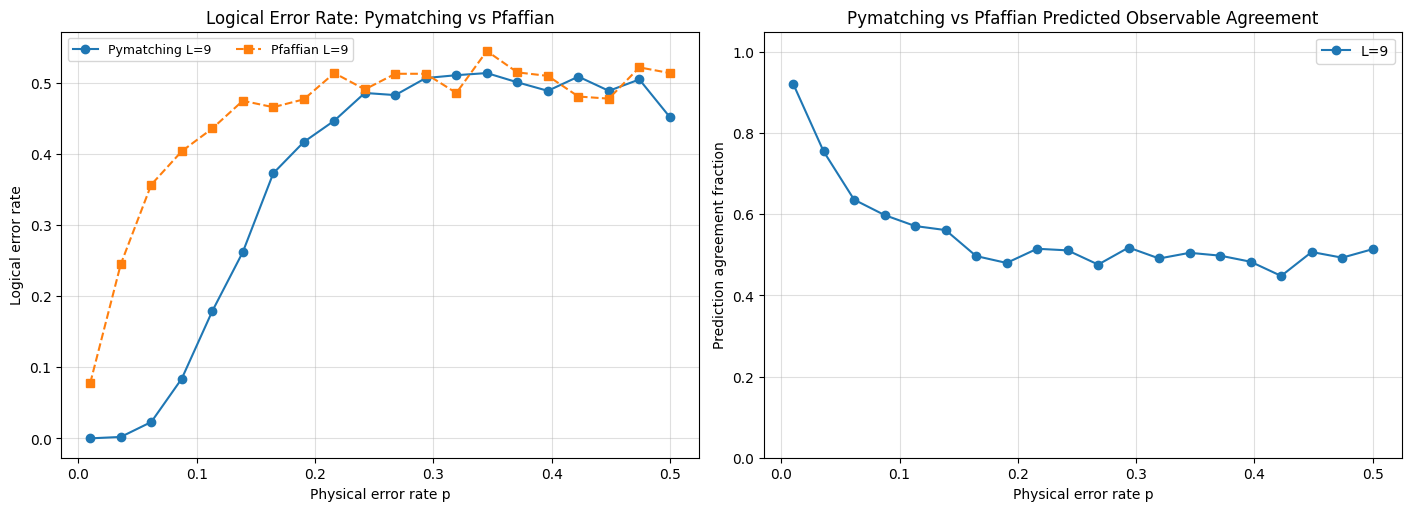

In [24]:
# --- Plot logical error rates ---  
fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)  
ax0, ax1 = axes  
  
for L in Ls:  
    pm_rates = [r['pm_rate'] for r in results[L]]  
    pf_rates = [r['pf_rate'] for r in results[L]]  
    ax0.plot(ps, pm_rates, 'o-', label=f'Pymatching L={L}')  
    ax0.plot(ps, pf_rates, 's--', label=f'Pfaffian L={L}')  
  
ax0.set_xlabel('Physical error rate p')  
ax0.set_ylabel('Logical error rate')  
ax0.set_title('Logical Error Rate: Pymatching vs Pfaffian')  
ax0.grid(alpha=0.4)  
ax0.legend(ncol=2, fontsize=9)  
  
for L in Ls:  
    agreement = [r['agreement'] for r in results[L]]  
    ax1.plot(ps, agreement, 'o-', label=f'L={L}')  
  
ax1.set_xlabel('Physical error rate p')  
ax1.set_ylabel('Prediction agreement fraction')  
ax1.set_ylim(0, 1.05)  
ax1.set_title('Pymatching vs Pfaffian Predicted Observable Agreement')  
ax1.grid(alpha=0.4)  
ax1.legend()  
plt.show()  

In [17]:
# --- Optional tabular summary ---  
try:  
    import pandas as pd  
  
    rows = []  
    for L in Ls:  
        for p, r in zip(ps, results[L]):  
            rows.append({  
                'L': L,  
                'p': float(p),  
                'pm_rate': r['pm_rate'],  
                'pf_rate': r['pf_rate'],  
                'agreement': r['agreement'],  
                't_pm_s': r['t_pm_s'],  
                't_pf_s': r['t_pf_s'],  
            })  
  
    df = pd.DataFrame(rows)  
    display(df)  
except ImportError:  
    print('pandas not installed; skipping table display')  

pandas not installed; skipping table display
